In [4]:

import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", palette="deep")

ROOT_DIR = Path("..").resolve()
if str(ROOT_DIR) not in sys.path:
    sys.path.append(str(ROOT_DIR))

from src import theory, NetworkConfig, NetworkAgentModel

output_dir = ROOT_DIR / 'outputs'
output_dir.mkdir(exist_ok=True)

data_dir = output_dir / 'data'
fig_dir = output_dir / 'figs'
data_dir.mkdir(parents=True, exist_ok=True)
fig_dir.mkdir(parents=True, exist_ok=True)

phi, theta = 0.54, 0.46
TARGET_SAMPLE_N = 50  # 理论/模拟统一采样数
n_m, n_w = 10, 5
BETA = 0.2  # 邻居耦合强度，非零以体现拓扑差异

chi_ref = theory.calculate_chi(phi, theta, k_avg=TARGET_SAMPLE_N)
rc_ref = theory.calculate_rc(n_m, n_w, chi_ref)
print(f"Theory Reference: chi={chi_ref:.4f}, rc={rc_ref:.4f}, sample_n={TARGET_SAMPLE_N}")

# Mode: Symmetric


Theory Reference: chi=9.5962, rc=0.7533, sample_n=50


Running Ultimate Theory Validation (Q & A)...
Simulating k=50 (Dense)...
Saved results to E:\newdesktop\emotion_dynamics\outputs\data\rq_a_scan_sym_k50_samp50_beta0.0_seeds10_steps300_v2.npz


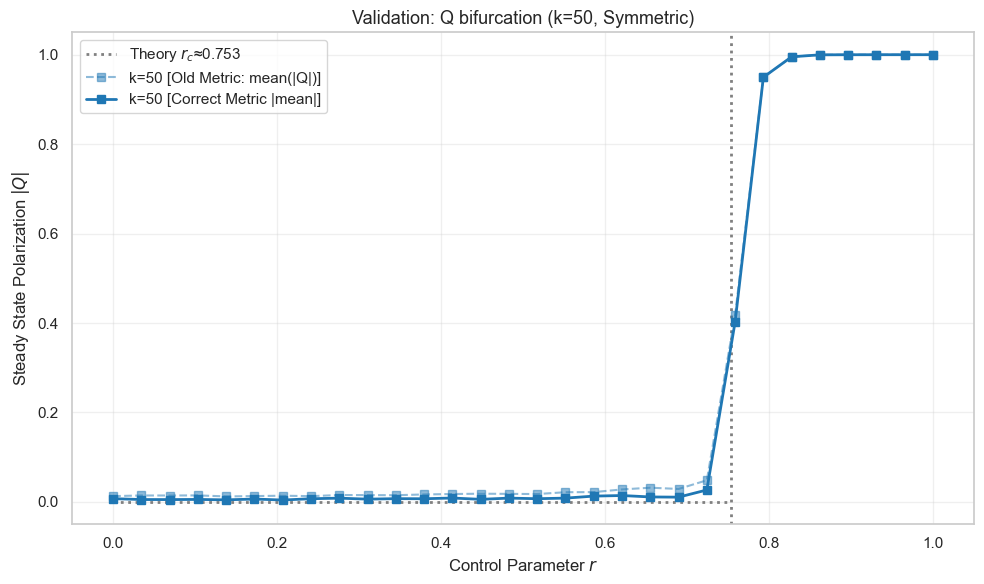

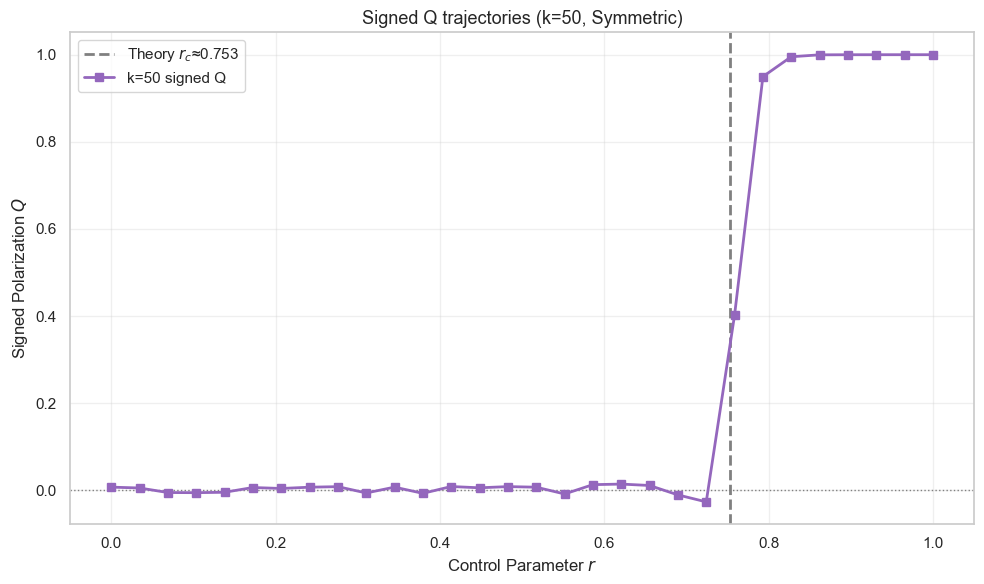

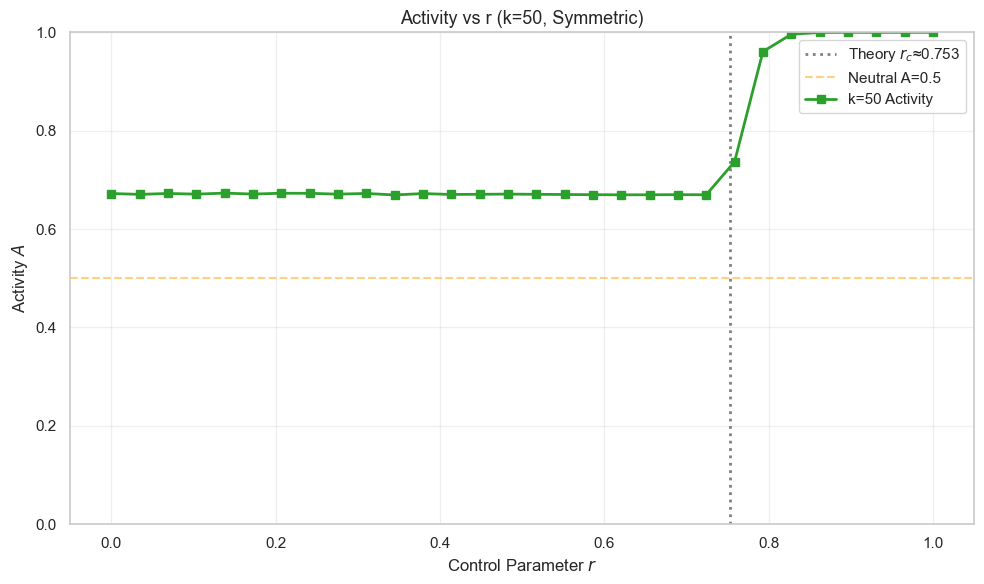

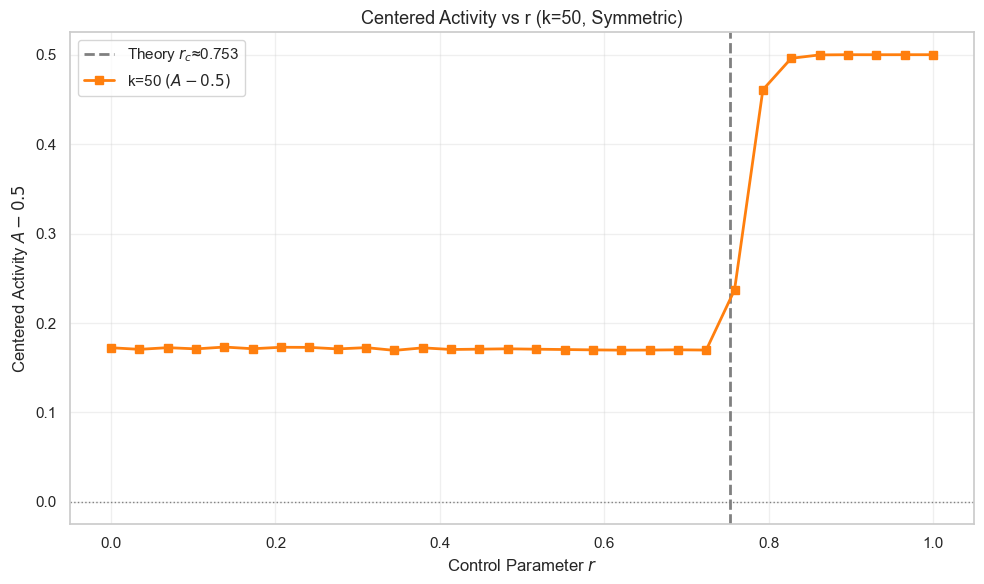

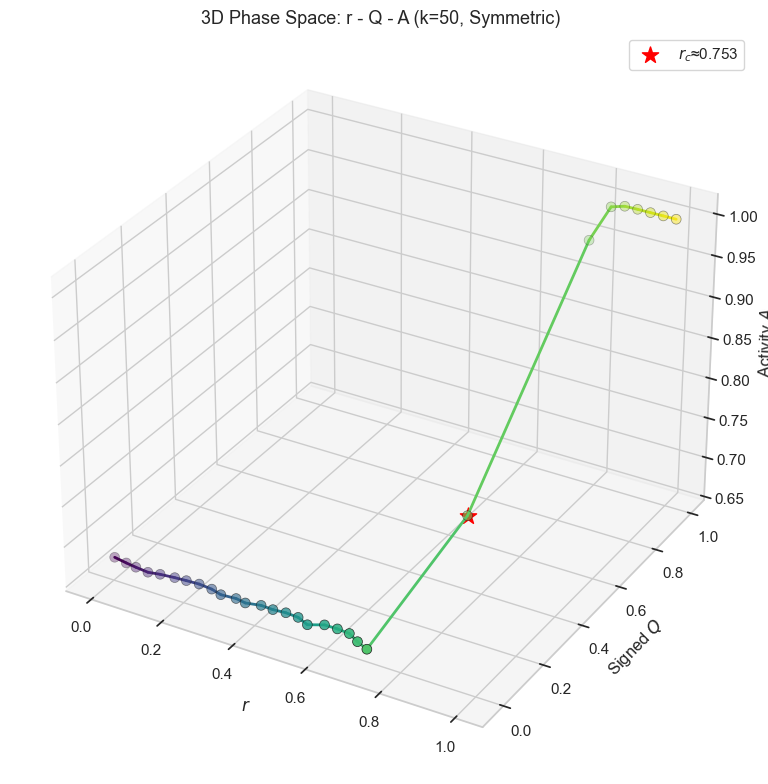

In [5]:

import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# 路径与导入
action_root = Path('..').resolve()
if str(action_root) not in sys.path:
    sys.path.append(str(action_root))

import numpy as np
import matplotlib.pyplot as plt
from src.network_sim import NetworkAgentModel, NetworkConfig
from src import theory

# 理论参考
phi, theta = 0.54, 0.46
n_m, n_w = 10, 5
chi_ref = theory.calculate_chi(phi, theta, k_avg=TARGET_SAMPLE_N)
rc_ref = theory.calculate_rc(n_m, n_w, chi_ref)

# 实验参数
N = 500
r_scan = np.linspace(0, 1.0, 30)
beta_fixed = 0.0  # 保持无耦合，验证理论基准
seeds = list(range(10))  # 增加到10个seeds以减少随机涨落
steps = 300
mode_tag = 'sym'
cache_name = f"rq_a_scan_sym_k{TARGET_SAMPLE_N}_samp{TARGET_SAMPLE_N}_beta{beta_fixed}_seeds{len(seeds)}_steps{steps}_v2.npz"
cache_path = data_dir / cache_name

# 拓扑配置（仅 k=50）
topology_setups = [
    {'k': 50,  'label': 'k=50 (Dense)', 'fmt': 's-'}
]

results = {cfg['label']: {'abs_mean': [], 'mean_abs': [], 'signed_mean': [], 'a_mean': [], 'a_signed': []} for cfg in topology_setups}
print("Running Ultimate Theory Validation (Q & A)...")

if cache_path.exists():
    loaded = np.load(cache_path)
    r_scan = loaded['r_scan']
    res = results['k=50 (Dense)']
    res['abs_mean'] = loaded['abs_mean']
    res['mean_abs'] = loaded['mean_abs']
    res['signed_mean'] = loaded['signed_mean']
    res['a_mean'] = loaded['a_mean']
    res['a_signed'] = loaded['a_signed']
    print('Loaded cached results from', cache_path)
else:
    for cfg in topology_setups:
        k = cfg['k']
        print(f"Simulating {cfg['label']}...")
        q_mean_abs_list = []  # 先取绝对值
        q_abs_mean_list = []  # 先平均再取绝对值
        q_signed_list = []    # 带符号
        a_mean_list = []      # 活跃度平均
        a_signed_list = []    # 活跃度相对中性点(0.5)的偏移

        for r in r_scan:
            q_ma_seeds = []
            q_am_seeds = []
            q_signed_seeds = []
            a_seeds = []
            a_signed_seeds = []
            for seed in seeds:
                net_cfg = NetworkConfig(
                    n=N, avg_degree=k, model="er", beta=beta_fixed,
                    r=r, n_m=n_m, n_w=n_w, phi=phi, theta=theta, seed=seed,
                    init_state="medium", sample_mode="fixed", sample_n=TARGET_SAMPLE_N, symmetric_mode=True,
                )
                model = NetworkAgentModel(net_cfg)
                _, q_traj, a_traj = model.run(steps=steps, record_interval=50)

                steady_q = q_traj[-5:]
                steady_a = a_traj[-5:]
                q_ma_seeds.append(np.mean(np.abs(steady_q)))
                q_am_seeds.append(np.abs(np.mean(steady_q)))
                q_signed_seeds.append(np.mean(steady_q))
                a_seeds.append(np.mean(steady_a))
                a_signed_seeds.append(np.mean(steady_a - 0.5))

            q_mean_abs_list.append(np.mean(q_ma_seeds))
            q_abs_mean_list.append(np.mean(q_am_seeds))
            # 对称性破缺处理：使用多数投票确定符号，然后用|mean|的值
            # 这样可以避免不同seeds选择不同极化方向导致的相互抵消
            signs = np.sign(q_signed_seeds)
            majority_sign = np.sign(np.sum(signs)) if np.sum(signs) != 0 else 1.0
            q_signed_list.append(majority_sign * np.mean(np.abs(q_signed_seeds)))
            a_mean_list.append(np.mean(a_seeds))
            a_signed_list.append(np.mean(a_signed_seeds))

        results[cfg['label']]['mean_abs'] = np.array(q_mean_abs_list)
        results[cfg['label']]['abs_mean'] = np.array(q_abs_mean_list)
        results[cfg['label']]['signed_mean'] = np.array(q_signed_list)
        results[cfg['label']]['a_mean'] = np.array(a_mean_list)
        results[cfg['label']]['a_signed'] = np.array(a_signed_list)

    # 保存缓存
    res = results['k=50 (Dense)']
    np.savez(cache_path, r_scan=r_scan, abs_mean=res['abs_mean'], mean_abs=res['mean_abs'], signed_mean=res['signed_mean'], a_mean=res['a_mean'], a_signed=res['a_signed'])
    print('Saved results to', cache_path)

# ============================================================
# 图2a: |Q| 分岔图（关键验证图）
# ============================================================
fig, ax = plt.subplots(figsize=(10, 6))
ax.axvline(rc_ref, color='gray', linestyle=':', linewidth=2, label=fr'Theory $r_c$≈{rc_ref:.3f}')
ax.hlines(0, 0, rc_ref, colors='gray', linestyles=':', linewidth=2)
res_k50 = results['k=50 (Dense)']
ax.plot(r_scan, res_k50['mean_abs'], 's--', color='tab:blue', alpha=0.5,
         label='k=50 [Old Metric: mean(|Q|)]')
ax.plot(r_scan, res_k50['abs_mean'], 's-', color='tab:blue', linewidth=2,
         label='k=50 [Correct Metric |mean|]')
ax.set_xlabel('Control Parameter $r$', fontsize=12)
ax.set_ylabel('Steady State Polarization $|Q|$', fontsize=12)
ax.set_title('Validation: Q bifurcation (k=50, Symmetric)', fontsize=13)
ax.legend()
ax.grid(True, alpha=0.3)
fig.tight_layout()
fig.savefig(fig_dir / 'fig2a_r_q_sym.png', dpi=200)
plt.show()

# ============================================================
# 图2b: Signed Q（带符号极化）
# ============================================================
fig, ax = plt.subplots(figsize=(10, 6))
ax.axhline(0, color='gray', linestyle=':', linewidth=1)
ax.axvline(rc_ref, color='gray', linestyle='--', linewidth=2, label=fr'Theory $r_c$≈{rc_ref:.3f}')
ax.plot(r_scan, results['k=50 (Dense)']['signed_mean'], 's-', color='tab:purple', 
        linewidth=2, label='k=50 signed Q')
ax.set_xlabel('Control Parameter $r$', fontsize=12)
ax.set_ylabel('Signed Polarization $Q$', fontsize=12)
ax.set_title('Signed Q trajectories (k=50, Symmetric)', fontsize=13)
ax.legend()
ax.grid(True, alpha=0.3)
fig.tight_layout()
fig.savefig(fig_dir / 'fig2b_signed_q_sym.png', dpi=200)
plt.show()

# ============================================================
# 图2c: Activity A（活跃度）
# ============================================================
fig, ax = plt.subplots(figsize=(10, 6))
ax.axvline(rc_ref, color='gray', linestyle=':', linewidth=2, label=fr'Theory $r_c$≈{rc_ref:.3f}')
ax.axhline(0.5, color='orange', linestyle='--', alpha=0.5, label='Neutral A=0.5')
ax.plot(r_scan, results['k=50 (Dense)']['a_mean'], 's-', color='tab:green', linewidth=2, label='k=50 Activity')
ax.set_xlabel('Control Parameter $r$', fontsize=12)
ax.set_ylabel('Activity $A$', fontsize=12)
ax.set_title('Activity vs r (k=50, Symmetric)', fontsize=13)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1)
fig.tight_layout()
fig.savefig(fig_dir / 'fig2c_activity_sym.png', dpi=200)
plt.show()

# ============================================================
# 图2d: Centered Activity (A - 0.5)
# ============================================================
fig, ax = plt.subplots(figsize=(10, 6))
ax.axhline(0, color='gray', linestyle=':', linewidth=1)
ax.axvline(rc_ref, color='gray', linestyle='--', linewidth=2, label=fr'Theory $r_c$≈{rc_ref:.3f}')
ax.plot(r_scan, results['k=50 (Dense)']['a_signed'], 's-', color='tab:orange', linewidth=2, label='k=50 $(A-0.5)$')
ax.set_xlabel('Control Parameter $r$', fontsize=12)
ax.set_ylabel('Centered Activity $A-0.5$', fontsize=12)
ax.set_title('Centered Activity vs r (k=50, Symmetric)', fontsize=13)
ax.legend()
ax.grid(True, alpha=0.3)
fig.tight_layout()
fig.savefig(fig_dir / 'fig2d_centered_activity_sym.png', dpi=200)
plt.show()

# ============================================================
# 图2e: 3D 相图 r - Q - A
# ============================================================
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
r_vals = r_scan
q_vals = results['k=50 (Dense)']['signed_mean']
a_vals = results['k=50 (Dense)']['a_mean']

# 使用颜色映射显示r的变化
colors = plt.cm.viridis(np.linspace(0, 1, len(r_vals)))
for i in range(len(r_vals)-1):
    ax.plot(r_vals[i:i+2], q_vals[i:i+2], a_vals[i:i+2], 
            color=colors[i], linewidth=2)
ax.scatter(r_vals, q_vals, a_vals, c=r_vals, cmap='viridis', s=50, edgecolor='k', linewidth=0.5)

# 标注临界点
rc_idx = np.argmin(np.abs(r_vals - float(rc_ref)))
ax.scatter([r_vals[rc_idx]], [q_vals[rc_idx]], [a_vals[rc_idx]], 
           color='red', s=150, marker='*', label=f'$r_c$≈{rc_ref:.3f}', zorder=10)

ax.set_xlabel('$r$', fontsize=12)
ax.set_ylabel('Signed $Q$', fontsize=12)
ax.set_zlabel('Activity $A$', fontsize=12)
ax.set_title('3D Phase Space: r - Q - A (k=50, Symmetric)', fontsize=13)
ax.legend()
fig.tight_layout()
fig.savefig(fig_dir / 'fig2e_3d_r_q_a_sym.png', dpi=200)
plt.show()


In [6]:
from src import theory

# 你的模型参数
phi, theta = 0.54, 0.46
n_m, n_w = 10, 5

# 情况 1：你现在的参照线 (k=50)
chi_50 = theory.calculate_chi(phi, theta, k_avg=50)
rc_50 = theory.calculate_rc(n_m, n_w, chi_50)
print(f"Theory r_c (k=50):   {rc_50:.4f}")

# 情况 2：你模拟的真实情况 (k=1999, Full Mesh N=2000)
chi_2000 = theory.calculate_chi(phi, theta, k_avg=1999)
rc_2000 = theory.calculate_rc(n_m, n_w, chi_2000)
print(f"Theory r_c (k=1999): {rc_2000:.4f}")

Theory r_c (k=50):   0.7533
Theory r_c (k=1999): 1.7859
